In [1]:
import os 
import json
import pandas as pd
import seaborn as sns
import numpy as np
import math

import pandas as pd
import matplotlib.pyplot as plt

from utils.analysys_utils import list_experiments_in_dir
from utils.derivatives import first_derivative

import torch


sns.set(font="Times New Roman")
font_size = '13'

In [2]:
experiments_path = os.path.join(os.getcwd(), "runs", "derivative_reg", "sidarthe_extended", "Italy")
figs_path = os.path.join(experiments_path, "figs") 
if not os.path.exists(figs_path):
    os.makedirs(figs_path)
experiments = list_experiments_in_dir(experiments_path)


In [3]:
def first_derivative_loss(params):
    der_loss_total = torch.zeros(1)
    
    for key, param in params.items():
        param = torch.tensor(param)
        der = first_derivative(param, 1)
        der_loss_total = der_loss_total + 0.5 * torch.pow(der, 2)

    return torch.mean(der_loss_total).numpy()
    
x = {
    'alpha': [1., 3., 5., 7., 9.]
}

print(first_derivative_loss(x))


2.0


In [4]:
# generate data for graphs

"""# take as baseline the exp with 0. regularization
base_val_loss = experiments[0]['final']['best_epoch']['val_loss']
base_der_loss = 0."""

data = []
indexes = []

for exp in experiments:
    try: #avoid NaNs
        val_loss = exp['final']['best_epoch']['val_loss']
    except:
        val_loss = np.nan

    
    der_1st_reg = exp['settings']['der_1st_reg']
    val_loss = exp['final']['best_epoch']['val_loss']

    if der_1st_reg != 0.:
        der_1st_loss = exp['final']['best_epoch']['losses']['der_1st']
        der_1st_norm = der_1st_loss / der_1st_reg
        initial_der_loss = float(first_derivative_loss(exp['settings']['initial_values']))
        initial_der_norm = initial_der_loss / der_1st_reg
    else:
        params = exp['final']['params']
        der_1st_loss = der_1st_norm = float(first_derivative_loss(params))
        initial_der_loss = float(first_derivative_loss(exp['settings']['initial_values']))
        initial_der_norm = initial_der_loss

    
        

    data.append({
        'val_loss': val_loss,
        'der_1st_reg': der_1st_reg,
        'der_1st': der_1st_loss,
        'initial_der_1st': initial_der_loss,
        'der_1st_norm': der_1st_norm,
        'initial_der_1st_norm': initial_der_norm
    })

    indexes.append(der_1st_reg)

index = pd.Index(indexes)
df = pd.DataFrame(data, index=index)
d_index = index.sort_values()

In [5]:
df['der_1st_norm']

1.000000e+03    0.000651
1.000000e+03    0.001062
1.000000e+11    0.000674
1.000000e+08    0.000746
1.000000e+08    0.000224
                  ...   
1.000000e+03    0.001516
1.000000e+00    0.001919
1.000000e+03    0.001122
1.000000e+05    0.001262
1.000000e+08    0.000832
Name: der_1st_norm, Length: 140, dtype: float64

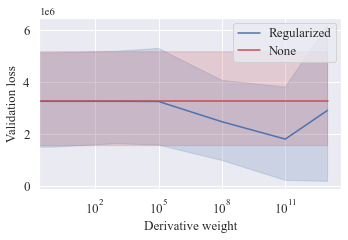

In [13]:
# plot reg weight vs validation loss
pl, ax = plt.subplots()
#ax.set_yscale('log')
ax.set_xscale('log')

sns.lineplot(data=df, x='der_1st_reg', y='val_loss', ax=ax, legend='brief', label="Regularized")


# add band for baseline (no momentum)
band_data = []

df_0d = df.loc[0.]
for i in range(0,len(df_0d)):
    val_loss = df_0d.iloc[i]['val_loss']
    band_data.append({
        'val_loss': val_loss,
        'd': d_index[0]
    })
    band_data.append({
        'val_loss': val_loss,
        'd': d_index[-1]
    })

band_df = pd.DataFrame(band_data)

plot = sns.lineplot(data=band_df, x='d', ax=ax, y='val_loss', label='None', legend='brief', color='r')

plot.set_xlabel("Derivative weight", fontsize=font_size)
plot.set_ylabel("Validation loss", fontsize=font_size)
plot.tick_params(labelsize=font_size)
texts = plot.get_legend().get_texts() 
plt.setp(texts, fontsize=font_size)

figure = plot.get_figure()
figure.set_size_inches((5,3.5))
figure.set_tight_layout(True)

figure.savefig(os.path.join(figs_path, "val_loss.pdf"),bbox_inches='tight')


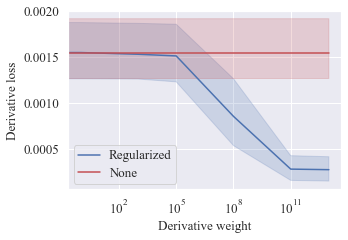

In [14]:
# plot reg weight vs der_loss

pl, ax = plt.subplots()
#ax.set_yscale('log')
ax.set_xscale('log')

plot = sns.lineplot(data=df, x='der_1st_reg', y='der_1st_norm', ax=ax, legend='brief', label="Regularized")
#plot = sns.lineplot(data=df, x='der_1st_reg', y='initial_der_1st_norm', ax=ax, legend='brief', label="Regularized (initial)")

plot.set(xlabel="Derivative Regularization", ylabel="Derivative loss")

# add band for baseline (no momentum)
band_data = []

df_0d = df.loc[0.]
for i in range(0,len(df_0d)):
    der_1st_loss = df_0d.iloc[i]['der_1st']
    der_1st_norm = df_0d.iloc[i]['der_1st_norm']
    initial_der_1st_norm = df_0d.iloc[i]['initial_der_1st_norm']
    band_data.append({
        'der_1st': der_1st_loss,
        'der_1st_norm': der_1st_norm,
        'initial_der_1st_norm': initial_der_1st_norm,
        'd': d_index[0]
    })
    band_data.append({
        'der_1st': der_1st_loss,
        'der_1st_norm': der_1st_norm,
        'initial_der_1st_norm': initial_der_1st_norm,
        'd': d_index[-1]
    })

band_df = pd.DataFrame(band_data)

plot = sns.lineplot(data=band_df, x='d', ax=ax, y='der_1st_norm', label='None', legend='brief', color='r')

plot.set(xlabel="Derivative weight", ylabel="Derivative loss")

plot.set_xlabel("Derivative weight", fontsize=font_size)
plot.set_ylabel("Derivative loss", fontsize=font_size)
plot.tick_params(labelsize=font_size)
texts = plot.get_legend().get_texts() 
plt.setp(texts, fontsize=font_size)

figure = plot.get_figure()
figure.set_size_inches((5,3.5))
figure.set_tight_layout(True)

figure.savefig(os.path.join(figs_path, "der_loss.pdf"), bbox_inches='tight')



In [8]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

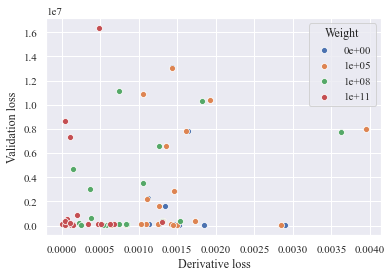

In [9]:
der_values = [0., 1e5, 1e8, 1e11]

pl, ax = plt.subplots()
#ax.set_yscale('log')

for der in der_values:
    df_d = df.loc[der]
    plot = sns.scatterplot(data=df_d, x='der_1st_norm', y='val_loss', label=f"{der:.0e}", ax=ax)



plot.set(xlabel="Derivative loss", ylabel="Validation loss")
plot.get_legend().set_title("Weight")


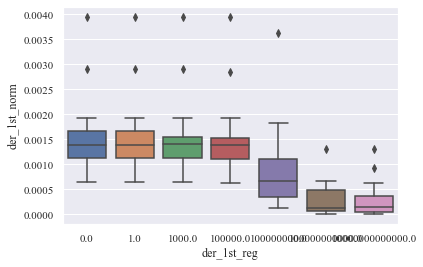

In [10]:
pl, ax = plt.subplots()
#ax.set_yscale('log')


plot = sns.boxplot(data=df, x='der_1st_reg', y='der_1st_norm')


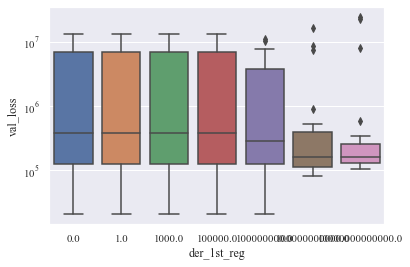

In [11]:
plot = sns.boxplot(data=df, x='der_1st_reg', y='val_loss')
plot.set_yscale('log')